In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("terror.csv",encoding='ISO-8859-1')
data = data[["iyear","imonth","iday","country","country_txt","extended","region",
            "region_txt","provstate","summary","success","suicide","attacktype1","attacktype1_txt"
            ,"targtype1","targtype1_txt","natlty1","gname","weaptype1","weaptype1_txt","nkill","nwound"
           ]]

C:\Users\gneur\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
data = data.dropna(axis=0, subset=['summary',"provstate","nwound"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107276 entries, 5 to 181690
Data columns (total 23 columns):
iyear              107276 non-null int64
imonth             107276 non-null int64
iday               107276 non-null int64
country            107276 non-null int64
country_txt        107276 non-null object
extended           107276 non-null int64
region             107276 non-null int64
region_txt         107276 non-null object
provstate          107276 non-null object
summary            107276 non-null object
success            107276 non-null int64
suicide            107276 non-null int64
attacktype1        107276 non-null int64
attacktype1_txt    107276 non-null object
targtype1          107276 non-null int64
targtype1_txt      107276 non-null object
natlty1            106172 non-null float64
gname              107276 non-null object
weaptype1          107276 non-null int64
weaptype1_txt      107276 non-null object
nkill              106968 non-null float64
nwound          

{'whiskers': [<matplotlib.lines.Line2D at 0x1e8d919f198>,
 'caps': [<matplotlib.lines.Line2D at 0x1e8d8ae9128>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e8d9c1a0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1e8d8234c88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e8d8234828>],
 'means': []}

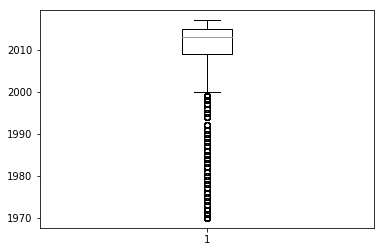

In [25]:
plt.boxplot(data["iyear"])

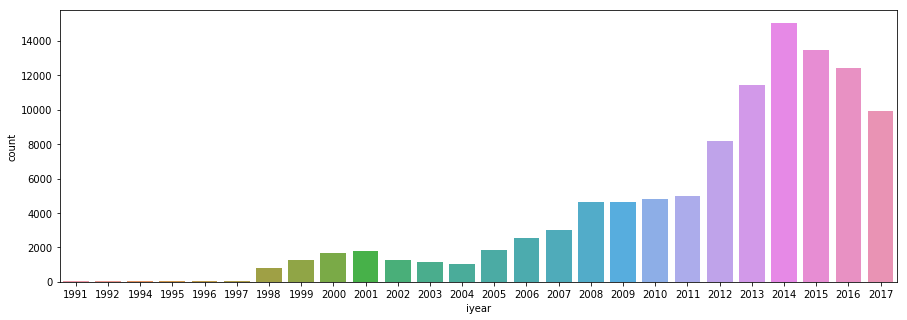

In [30]:
data = data[data["iyear"] > 1990]
fig = plt.figure(figsize = (15,5))
fig = sns.countplot(data["iyear"])
plt.show()

In [70]:
country = data["country_txt"].value_counts() 
country = country[country >40]
country

Iraq                                23251
Pakistan                            12264
Afghanistan                         11880
India                                8708
Philippines                          4795
Thailand                             3598
Somalia                              2986
Nigeria                              2856
Yemen                                2852
Colombia                             2175
Egypt                                1963
Libya                                1924
Russia                               1881
Turkey                               1879
Ukraine                              1561
Algeria                              1512
Syria                                1495
West Bank and Gaza Strip             1287
United Kingdom                       1200
Israel                               1145
Nepal                                1118
Bangladesh                           1063
Sri Lanka                             870
United States                     

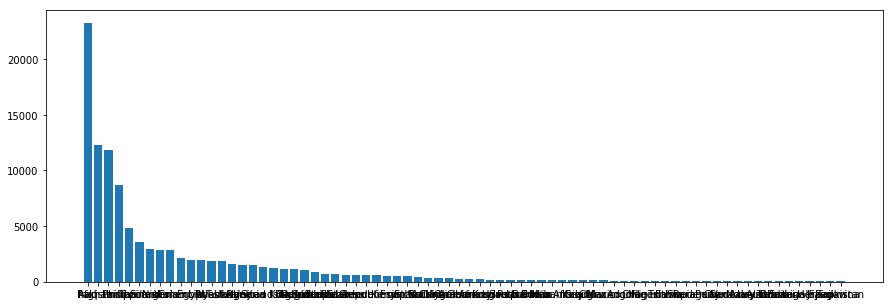

In [73]:
fig = plt.figure(figsize = (15,5))
fig = plt.bar(country.index,country)
plt.show()